# Network characterization (part 2)
In this notebook:
* Creation of four synthetic models 
* Comparison between synthetic models and RW
     * Degree
     * Clustering Coefficient
     * Connected Component Analysis
     * Density Analysis
     * Path Analysis
     * Node Assortativity
    

### Load libraries and model creation

In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import powerlaw
import matplotlib.colors as mcolors
from operator import itemgetter
from collections import Counter
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_palette("Set2")
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)


In [5]:
df = pd.read_csv("../data_collection/data/df_nickname.csv", skipinitialspace=True, na_values='?', keep_default_na=True)   
df.username_mittente = df.username_mittente.astype(str)
df.username_ricevente = df.username_ricevente.astype(str)

rw = nx.from_pandas_edgelist(df, source="username_mittente", target = "username_ricevente", create_using=nx.MultiDiGraph(), edge_attr = "weights")
ws = nx.watts_strogatz_graph(52795, k=4, p=0.2, seed = 42)




In [ ]:
er = nx.erdos_renyi_graph(52795, 0.000005, directed = True, seed = 42)


In [ ]:
nx.write_gexf(er, "json/ER.gexf")

In [6]:
er = nx.read_gexf("json/ER.gexf")

In [7]:
ba = nx.barabasi_albert_graph(52795, 2, seed = 42)


In [10]:
nx.write_gexf(ba, "json/BA.gexf")

In [8]:
sequence = [i[1] for i in rw.degree()]
cm = nx.configuration_model(sequence)

In [12]:
nx.write_gexf(cm, "json/CM.gexf")

### Functions

In [10]:
def find_hubs(G, degree_threshold):
    '''Function for extracting hubs and not hubs from the network'''
    hubs = []
    notHubs = []
    for i in G:
        if G.degree(i) >= degree_threshold:
            hubs.append(i)
        else:
            notHubs.append(i)
    print(len(hubs))
    return hubs, notHubs

def print_network_info(g):
    '''Function to print info about the network'''
    n_nodes = g.number_of_nodes()
    n_edges = g.number_of_edges()
    print ("Number of nodes: ", n_nodes)
    print ("Number of edges: ", n_edges)
    print ("Number of self-loop: ", nx.number_of_selfloops(g))
    print("Is directed graph: ", g.is_directed())
    l_max = ((n_nodes) * (n_nodes - 1)) / 2
    print("LMAX: ", l_max)
    avg_degree = (2*n_edges)/n_nodes
   # print("clustering coeff ", clust_coeff_density_info(g))
  #  print("Average degree: ", avg_degree)
  #  print("Shortest path ", nx.shortest_path_length(g, source = 0))


def clust_coeff_density_info(g):
    print("Average clustering coeff: ", nx.average_clustering(g))
    
    
def plot_dist(G):
    M = nx.to_scipy_sparse_matrix(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).A[0]
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)
    
    
    fig = plt.figure(figsize=(16, 6)) 
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.',c=sns.color_palette()[9])   
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')


    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf(c=sns.color_palette()[9])
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf(c=sns.color_palette()[9])
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    plt.show()
    

    
def draw_graph(g):
    plt.figure(figsize=(17,16))
    pos = nx.spring_layout(g, k =5)
    M = g.number_of_edges()
    edge_colors = range(2, M + 2)
    nodes = nx.draw_networkx_nodes(g, pos,node_size=300, node_color="#AAAAFF")
    edges = nx.draw_networkx_edges(g,pos,arrowstyle="->", arrowsize=8,  
                                   edge_color=edge_colors,
                                   edge_cmap=cmap, width = 1)
    nx.draw_networkx_labels(g, pos, font_size=20, font_color="black")
    plt.tight_layout()
    plt.show()
    
    
def degree_dist_plot(graphs):
    fig = plt.figure(figsize=(16,8))
    labels = []
    for i in graphs:
        if i[0].is_directed():
            degrees = i[0].in_degree() # dictionary node:degree
        else:
            degrees = i[0].degree() # dictionary node:degree
        values = sorted(set([v for k, v in degrees]))
        hist = [[v for k, v in degrees].count(x) for x in values]
        labels.append(i[1])
        if(i[1] == "Real World"):
            plt.loglog(values, hist, 'o-') # in-degree
        else:
            plt.loglog(values, hist, 'o') # in-degree
    fontsize = 15
    
    plt.yticks(fontsize=fontsize, alpha=1)
    plt.xlabel("Degree", fontsize=fontsize)
    plt.ylabel("Number of nodes", fontsize=fontsize)
    plt.title("Degree Distribution", fontsize=fontsize)
    plt.legend(labels, fontsize=fontsize)
    plt.grid(axis='both', alpha=.3)
    plt.xlim([0, 2*10**2])
    
    plt.show()

In [6]:
network_list = [ws, er, ba, rw, cm]
network_names = ["Watts Strogats", "Erdos-Renyi", "Barabasi Albert", "Real World", "Configuration Model"]

In [12]:
for net, net_name in zip(network_list, network_names):
    print(f"\nModel: {net_name}\n----------------------------")
    print_network_info(net)



Model: Watts Strogats
----------------------------
Number of nodes:  52795
Number of edges:  105590
Number of self-loop:  0
Is directed graph:  False
LMAX:  1393629615.0

Model: Erdos-Renyi
----------------------------
Number of nodes:  52795
Number of edges:  13786
Number of self-loop:  0
Is directed graph:  True
LMAX:  1393629615.0

Model: Barabasi Albert
----------------------------
Number of nodes:  52795
Number of edges:  105586
Number of self-loop:  0
Is directed graph:  False
LMAX:  1393629615.0

Model: Real World
----------------------------
Number of nodes:  52795
Number of edges:  81063
Number of self-loop:  1
Is directed graph:  True
LMAX:  1393629615.0

Model: Configuration Model
----------------------------
Number of nodes:  52795
Number of edges:  81063
Number of self-loop:  19
Is directed graph:  False
LMAX:  1393629615.0


In [59]:
sorted(er.degree, key=lambda x: x[1], reverse=False)


[('2', 0),
 ('3', 0),
 ('4', 0),
 ('5', 0),
 ('7', 0),
 ('8', 0),
 ('9', 0),
 ('10', 0),
 ('14', 0),
 ('15', 0),
 ('16', 0),
 ('17', 0),
 ('19', 0),
 ('21', 0),
 ('22', 0),
 ('27', 0),
 ('28', 0),
 ('30', 0),
 ('31', 0),
 ('32', 0),
 ('35', 0),
 ('36', 0),
 ('39', 0),
 ('40', 0),
 ('44', 0),
 ('48', 0),
 ('49', 0),
 ('50', 0),
 ('51', 0),
 ('52', 0),
 ('53', 0),
 ('55', 0),
 ('56', 0),
 ('57', 0),
 ('59', 0),
 ('60', 0),
 ('61', 0),
 ('64', 0),
 ('65', 0),
 ('66', 0),
 ('69', 0),
 ('70', 0),
 ('71', 0),
 ('76', 0),
 ('77', 0),
 ('78', 0),
 ('80', 0),
 ('81', 0),
 ('84', 0),
 ('85', 0),
 ('86', 0),
 ('89', 0),
 ('91', 0),
 ('92', 0),
 ('95', 0),
 ('96', 0),
 ('97', 0),
 ('98', 0),
 ('99', 0),
 ('100', 0),
 ('101', 0),
 ('102', 0),
 ('108', 0),
 ('109', 0),
 ('110', 0),
 ('112', 0),
 ('113', 0),
 ('118', 0),
 ('120', 0),
 ('121', 0),
 ('122', 0),
 ('123', 0),
 ('125', 0),
 ('129', 0),
 ('131', 0),
 ('132', 0),
 ('133', 0),
 ('135', 0),
 ('136', 0),
 ('137', 0),
 ('138', 0),
 ('139', 0),


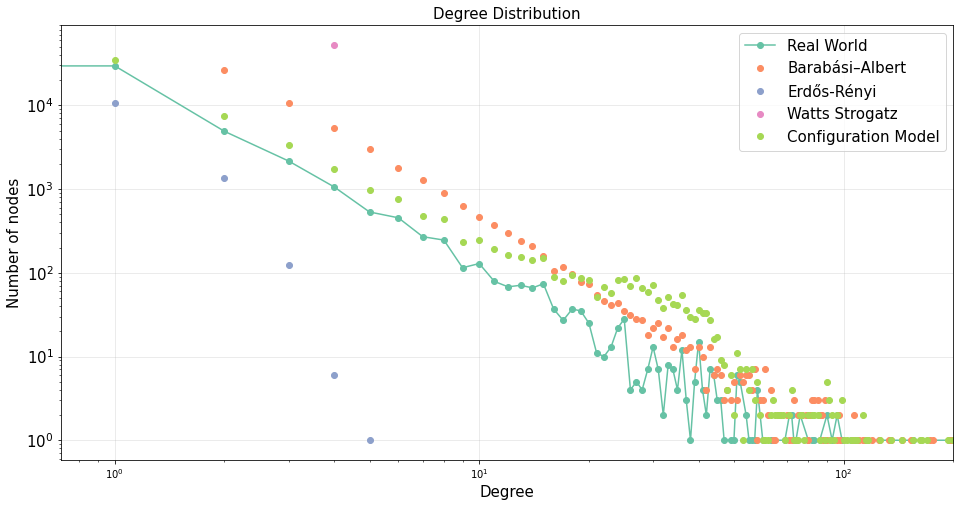

In [9]:
graphs = [(rw, "Real World"), (ba, "Barabási–Albert"), (er, "Erdős-Rényi"), (ws, "Watts Strogatz"), (cm, "Configuration Model")]
degree_dist_plot(graphs)

### Connected Component



In [20]:
comps = list(nx.connected_components(rw.to_undirected()))
print("Number of connected components: ", len(comps))

Number of connected components:  3138


In [14]:
comps = list(nx.connected_components(er.to_undirected()))
print("Number of Connected Components (ER): ", len(comps))

Number of Connected Components (ER):  39009


In [15]:
comps = list(nx.connected_components(ws))
print("Number of Connected Components (WS): ", len(comps))

Number of Connected Components (WS):  1


In [16]:
comps = list(nx.connected_components(ba))
print("Number of Connected Components (BA): ", len(comps))

Number of Connected Components (BA):  1


In [17]:
comps = list(nx.connected_components(cm))
print("Number of Connected Components (CM): ", len(comps))


Number of Connected Components (CM):  4018


In [26]:
print('Number weakly connected components: ', str(nx.number_weakly_connected_components(er)))
print('Number strongly connected components: ', str(nx.number_strongly_connected_components(er)))
print('Number weakly connected components: ', str(nx.number_weakly_connected_components(rw)))
print('Number strongly connected components: ', str(nx.number_strongly_connected_components(rw)))

Number weakly connected components:  39009
Number strongly connected components:  52795
Number weakly connected components:  3138
Number strongly connected components:  52770


In [11]:
RW_dir = nx.MultiGraph(rw)
RW_components = list(nx.connected_components(RW_dir))
print('Number of connected components (RW): ', len(RW_components))
RW_biggest_component = len(RW_components[0])
print('Size of the biggest component (RW): ', RW_biggest_component)


Number of connected components (RW):  3138
Size of the biggest component (RW):  38444


In [12]:
ER_dir = nx.MultiGraph(rw)
ER_components = list(nx.connected_components(ER_dir))
print('Number of connected components (ER): ', len(ER_components))
ER_biggest_component = len(ER_components[0])
print('Size of the biggest component (ER): ', ER_biggest_component)


Number of connected components (ER):  3138
Size of the biggest component (ER):  38444


In [13]:
BA_dir = nx.MultiGraph(ba)
BA_components = list(nx.connected_components(BA_dir))
print('Number of connected components (ER): ', len(BA_components))
BA_biggest_component = len(BA_components[0])
print('Size of the biggest component (ER): ', BA_biggest_component)


Number of connected components (ER):  1
Size of the biggest component (ER):  52795


In [15]:
WS_dir = nx.MultiGraph(ws)
WS_components = list(nx.connected_components(WS_dir))
print('Number of connected components (ER): ', len(WS_components))
WS_biggest_component = len(WS_components[0])
print('Size of the biggest component (ER): ', WS_biggest_component)


Number of connected components (ER):  1
Size of the biggest component (ER):  52795


### Clustering Coefficient and Density analysis

In [65]:
def clust_coeff_density_info(g):
    print("Average clustering coeff: ", nx.average_clustering(g))
    print("Density': ", nx.density(g))

In [66]:
print("RW:  \n\t", clust_coeff_density_info(rw), "\n")
print("WS:  \n\t", clust_coeff_density_info(ws), "\n")
print("ER:  \n\t", clust_coeff_density_info(er), "\n")
print("BA:  \n\t", clust_coeff_density_info(ba), "\n")
cm_g = nx.Graph(cm)
print("CM:  \n\t", clust_coeff_density_info(cm_g))


Average clustering coeff:  0.015483362139543686
Density':  2.9083408937173023e-05
RW:  
	 None 

Average clustering coeff:  0.5
Density':  7.576618555138841e-05
WS:  
	 None 

Average clustering coeff:  0.0
Density':  4.9460774410997286e-06
ER:  
	 None 

Average clustering coeff:  0.0015903108632427656
Density':  7.5763315348318e-05
BA:  
	 None 

Average clustering coeff:  0.0026379974338497114
Density':  5.793074367180408e-05
CM:  
	 None


### Path analysis

In [27]:
def sample_data(g): 
    degree_calc = {node: val for (node, val) in g.degree()}
    degree = dict(sorted(degree_calc.items(), key=lambda item: item[1], reverse = True))
    sample = []
    for k, v in degree.items():
        if(v >=  1):
            sample.append(k) 
    g = nx.to_undirected(g)
    sample_data = g.subgraph(sample)
    return sample_data



In [34]:

    for k, v in degree.items():
        if(v >=  1):
            sample.append(k) 
    g = nx.to_undirected(g)
    sample_data = g.subgraph(sample)
    return sample_data

Gcc = sorted(nx.connected_components(rw.to_undirected()), key=len, reverse=True)
rw.remove_nodes_from([n for n in rw if n not in set(Gcc[0])])

In [36]:
from random import sample

G = rw.to_undirected().copy()
conn_comps = sorted(nx.connected_components(G), key=len, reverse=True) 
G.remove_nodes_from([n for n in G if n not in set(conn_comps[0])])

sampled_nodes = sample(G.nodes, 25000)  
G.remove_nodes_from([n for n in G if n not in set(sampled_nodes)])

conn_comps_sample = sorted(nx.connected_components(G), key=len, reverse=True)
G.remove_nodes_from([n for n in G if n not in set(conn_comps_sample[0])])

In [38]:
comps = list(nx.connected_components(G))
print("Number of Connected Components (g): ", len(comps))

#max([max(j.values()) for (i,j) in nx.shortest_path_length(g)])
print("Average shortest path (g):", nx.average_shortest_path_length(G.subgraph(comps[0])))
print("Average shortest path weighted (g):", nx.average_shortest_path_length(G.subgraph(comps[0]), weight='weight'))

Number of Connected Components (g):  1
Average shortest path (g): 6.246038499855545
Average shortest path weighted (g): 6.246038499855545


In [9]:

er = nx.to_undirected(er)
comps = list(nx.connected_components(er))
print("Number of Connected Components (g): ", len(comps))

#max([max(j.values()) for (i,j) in nx.shortest_path_length(g)])
print("Average shortest path (g):", nx.average_shortest_path_length(er.subgraph(comps[0])))
print("Average shortest path weighted (g):", nx.average_shortest_path_length(er.subgraph(comps[0])))

Number of Connected Components (g):  39009
Average shortest path (g): 1.6666666666666667
Average shortest path weighted (g): 1.6666666666666667


In [ ]:
ba = nx.to_undirected(ba)
comps = list(nx.connected_components(ba))

print("Number of Connected Components (g): ", len(comps))

#max([max(j.values()) for (i,j) in nx.shortest_path_length(g)])
print("Average shortest path (g):", nx.average_shortest_path_length(ba.subgraph(comps[0])))

print("Average shortest path weighted (g):", nx.average_shortest_path_length(ba.subgraph(comps[0])))

Number of Connected Components (g):  1
Average shortest path (g): 5.615018822630287


In [10]:
cm = nx.to_undirected(cm)
comps = list(nx.connected_components(cm))
print("Number of Connected Components (g): ", len(comps))

#max([max(j.values()) for (i,j) in nx.shortest_path_length(g)])
print("Average shortest path (g):", nx.average_shortest_path_length(cm.subgraph(comps[0])))
print("Average shortest path weighted (g):", nx.average_shortest_path_length(cm.subgraph(comps[0])))

Number of Connected Components (g):  4170
Average shortest path (g): 4.970502775694035
Average shortest path weighted (g): 4.970502775694035


In [9]:
ws = nx.to_undirected(ws)
comps = list(nx.connected_components(ws))
print("Number of Connected Components (g): ", len(comps))

#max([max(j.values()) for (i,j) in nx.shortest_path_length(g)])
print("Average shortest path (g):", nx.average_shortest_path_length(ws.subgraph(comps[0])))
print("Average shortest path weighted (g):", nx.average_shortest_path_length(ws.subgraph(comps[0])))

Number of Connected Components (g):  1


KeyboardInterrupt: 